## Семинар 1 "Полносвязные нейронные сети"

ФИО: Гасанов Марат Шамильевич

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400/>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [35]:
np.random.seed(10)

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = Wx$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times n}$, $W \in \mathbb{R}^{n \times m}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_{kt} = (Wx)_{kt} = \sum_{z=1}^{n} x_{kz}W_{zt}$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}\frac{\partial w_{jt}}{\partial x_{ij}}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W^T$$

In [36]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size) * 0.1
        self.b = np.zeros(output_size)
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''

        # print("W dim " + str(self.W.shape))
        self.X = X
        # print("X dim " + str(self.X.shape))
        # print("b dim " + str(self.b.shape))
        self.Y = X @ self.W + self.b
        #### YOUR CODE HERE
        #### Apply layer to input
        return self.Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        #### YOUR CODE HERE
        # print("X dim " + str(self.X.shape))
        # print("W dim " + str(self.W.shape))
        # print("b dim " + str(self.b.shape))
        # print("dLdy dim " + str(dLdy.shape))

        self.dLdx = dLdy @ self.W.T
        self.dLdw = np.expand_dims(self.X, -1) * np.expand_dims(dLdy, -2)
        self.dLdw = dLdy.T @ self.X
        self.dLdb = dLdy
        # print("dLx dim " + str(self.dLdx.shape))
        # print("dldW dim " + str(self.dLdw.shape))
        # print("dldb dim " + str(self.dLdb.shape))

        if len(self.dLdb.shape) > 1:
            self.dLdb = self.dLdb.sum(0)
        return self.dLdx
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        # print(self.W.shape)
        # print(self.b.shape)
        # print(self.dLdw.shape)
        # print(self.dLdb.shape)
        self.W = self.W - learning_rate*self.dLdw.T
        self.b = self.b - learning_rate*self.dLdb

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [37]:
def num_gradient(X, func, eps=10**-6):
    X_full = np.ravel(X)
    grad_X = np.zeros(X_full.shape)
    for i in range(len(X_full)):
            X_full[i] += eps
            f_plus =  func(X_full)
            X_full[i] -= eps
            X_full[i] -= eps
            f_minus = func(X_full)
            X_full[i] += eps
            grad_X[i] = (f_plus - f_minus)/2/eps
    return grad_X

In [38]:
def num_gradient_W(W, func, eps=10**(-6)):
    grad_W = np.zeros(W.shape)
    for i in range(grad_W.shape[0]):
        for j in range(grad_W.shape[1]):
            W[i, j] += eps
            f_plus =  func(W)
            W[i, j] -= eps
            W[i, j] -= eps
            f_minus = func(W)
            W[i, j] += eps
            grad_W[i, j] = (f_plus - f_minus)/2/eps
    return grad_W

Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [39]:
#### YOUR CODE HERE
linear = Linear(4, 3)
sample_X = np.array([.03, .7, .8, .23])
sample_X = np.random.rand(1, 4)

In [40]:
f = lambda x: linear.forward(x).sum()
num_gradient(sample_X, f)

array([ 0.05014652, -0.01071334,  0.03783515,  0.14614634])

In [41]:
linear.forward(sample_X)
linear.backward(np.ones([1,3]))
linear.dLdx

array([[ 0.05014652, -0.01071334,  0.03783515,  0.14614634]])

In [42]:
def f_w(W, linear=linear, sample_x=sample_X):
    linear.W = W
    return linear.forward(sample_x).sum()
linear.forward(sample_X)
num_gradient_W(linear.W, func=f_w)

array([[0.72175532, 0.72175532, 0.72175532],
       [0.29187607, 0.29187607, 0.29187607],
       [0.91777412, 0.91777412, 0.91777412],
       [0.71457578, 0.71457578, 0.71457578]])

In [43]:
linear.forward(sample_X)
linear.backward(np.ones([1, 3]))
linear.dLdw

array([[0.72175532, 0.29187607, 0.91777412, 0.71457578],
       [0.72175532, 0.29187607, 0.91777412, 0.71457578],
       [0.72175532, 0.29187607, 0.91777412, 0.71457578]])

### Часть 3: Сигмоида

In [44]:
class Sigmoid:
    def __init__(self):
        self.sigmoid_func = lambda x: 1/(1 + np.exp(-x))
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        self.y = self.sigmoid_func(X)
        self.X = X
        return self.y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        self.dLdx = dLdy * self.sigmoid_func(self.X) * (1 - self.sigmoid_func(self.X))
        return self.dLdx

    def step(self, learning_rate=0):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [45]:
#### YOUR CODE HERE
sigmoid = Sigmoid()
sample_x = np.random.rand(4)

In [46]:
f_sigm = lambda x: sigmoid.forward(x).sum()
num_gradient(sample_x, f_sigm)

array([0.23246915, 0.24874097, 0.24148699, 0.2236171 ])

In [47]:
sigmoid.forward(sample_x)
sigmoid.backward(np.ones(4))

array([0.23246915, 0.24874097, 0.24148699, 0.2236171 ])

### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://blog.feedly.com/tricks-of-the-trade-logsumexp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [48]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.L = -X[range(np.shape(X)[0]), y] + np.log(np.sum(np.exp(X), axis=1))
        self.X = X
        self.y = y
        #### YOUR CODE HERE
        #### Apply layer to input
        return self.L
    
    def backward(self, dLdy=0):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        self.dLdx = np.exp(self.X)/np.tile( np.sum(np.exp(self.X), axis=1).reshape(np.shape(self.X)[0],1), (1, np.shape(self.X)[1]))
        self.dLdx[range(np.shape(self.X)[0]), self.y] -= 1
        return self.dLdx
        pass

    def step(self, learning_rate=0):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [49]:
nll = NLLLoss()
X = np.random.rand(10, 5)
y = np.random.randint(0, 4, 10)

In [50]:
nll.forward(X, y)
nll.backward()

array([[ 0.18213652,  0.18071792, -0.78282785,  0.19559801,  0.2243754 ],
       [ 0.18994093, -0.76703287,  0.17544425,  0.25835201,  0.14329569],
       [-0.84145515,  0.19564039,  0.16231884,  0.33170948,  0.15178644],
       [ 0.19806883, -0.81692176,  0.24023424,  0.12918881,  0.24942986],
       [ 0.16342151, -0.75547248,  0.1545692 ,  0.2782769 ,  0.15920486],
       [-0.83606268,  0.20581908,  0.15261656,  0.31594683,  0.1616802 ],
       [ 0.13869347, -0.75715763,  0.25360484,  0.14907602,  0.2157833 ],
       [ 0.14159524,  0.20013059, -0.72837289,  0.18794632,  0.19870073],
       [-0.83494842,  0.22682029,  0.17184439,  0.21538695,  0.22089679],
       [ 0.2708275 ,  0.13000995, -0.80806745,  0.17115656,  0.23607344]])

In [51]:
f_nll = lambda x: nll.forward(x, y).sum()
num_gradient_W(X, f_nll)

array([[ 0.18213652,  0.18071792, -0.78282785,  0.19559801,  0.2243754 ],
       [ 0.18994093, -0.76703287,  0.17544425,  0.25835201,  0.14329569],
       [-0.84145515,  0.19564039,  0.16231884,  0.33170948,  0.15178644],
       [ 0.19806883, -0.81692176,  0.24023424,  0.12918881,  0.24942986],
       [ 0.16342151, -0.75547248,  0.1545692 ,  0.2782769 ,  0.15920486],
       [-0.83606268,  0.20581908,  0.15261656,  0.31594683,  0.1616802 ],
       [ 0.13869347, -0.75715763,  0.25360484,  0.14907602,  0.2157833 ],
       [ 0.14159524,  0.20013059, -0.72837289,  0.18794632,  0.19870073],
       [-0.83494842,  0.22682029,  0.17184439,  0.21538695,  0.22089679],
       [ 0.2708275 ,  0.13000995, -0.80806745,  0.17115656,  0.23607344]])

### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [52]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        #### YOUR CODE HERE
        self.layers = modules
        pass
    
    def forward(self, X):
        #### YOUR CODE HERE
        #### Apply layers to input
        currX = X
        for layer in self.layers:
            currX = layer.forward(currX)
        return currX

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        #### YOUR CODE HERE
        currdLdy = dLdy
        for layer in reversed(self.layers):
            currdLdy = layer.backward(currdLdy)
    
    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

    def predict(self, X):
        pred = self.forward(X)
        return np.argmax(pred, axis=1)

### Часть 6, обучение на простых данных

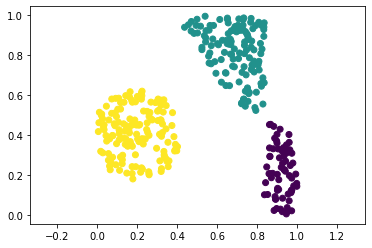

In [53]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).

In [54]:
### YOUR CODE HERE:
layers = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]
nn = NeuralNetwork(layers)

In [55]:
loss = NLLLoss()

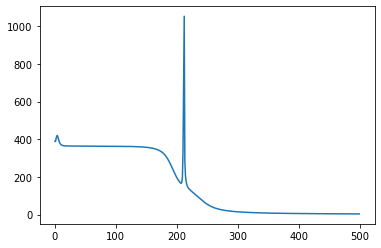

3.256430909844857

In [56]:
def fit(nn, loss, n_epoch, learning_rate):
    loss_array = []
    for epoch in range(n_epoch):
        nn_predict = nn.forward(X)
        L = loss.forward(nn_predict, y)
        loss_array.append(L.sum())
        dLdy = loss.backward()
        nn.backward(dLdy)
        nn.step(learning_rate)
        # print(epoch/n_epoch)
    plt.plot(loss_array)
    plt.show()
    return loss_array[-1]
fit(nn, loss, 500, 0.005)

3. Нарисуйте разделяющую поверхность

In [57]:
from mlxtend.plotting import plot_decision_regions

<AxesSubplot:>

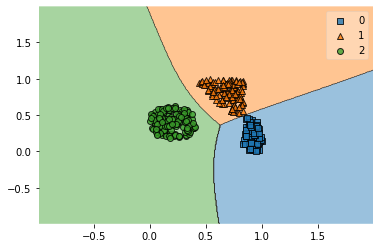

<AxesSubplot:>

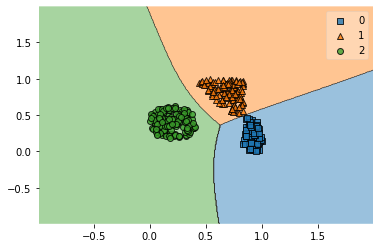

In [58]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plot_decision_regions(X, y, nn)

4. Попробуйте подобрать темп обучения. Как меняется сходимость?

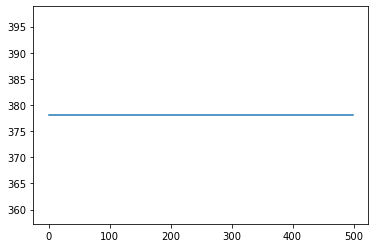

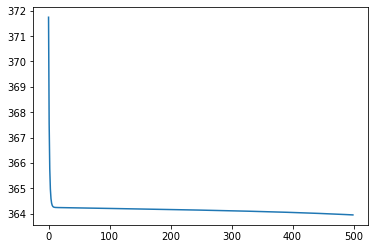

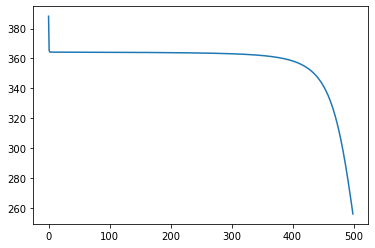

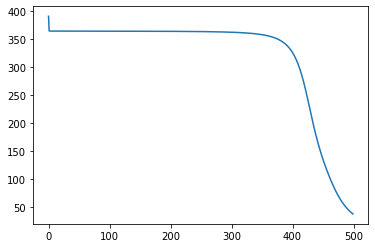

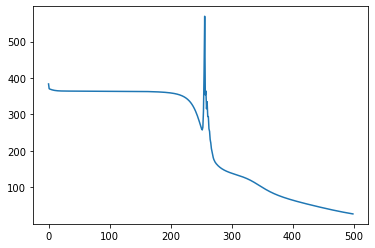

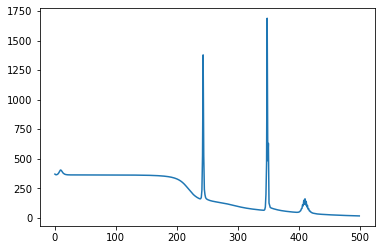

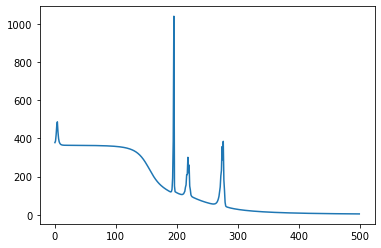

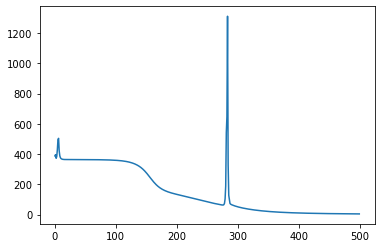

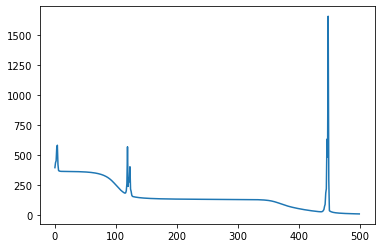

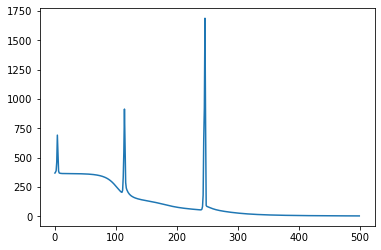

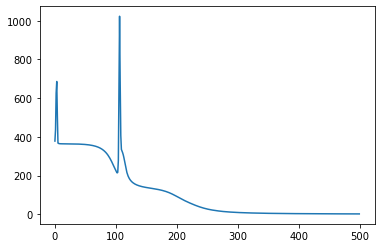

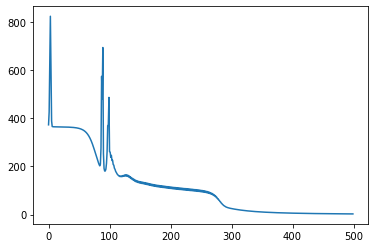

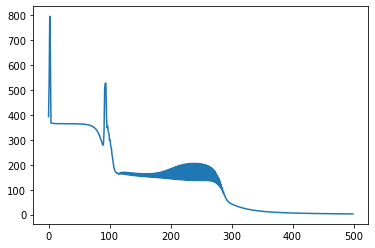

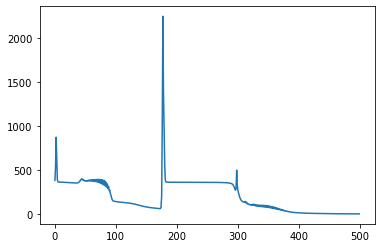

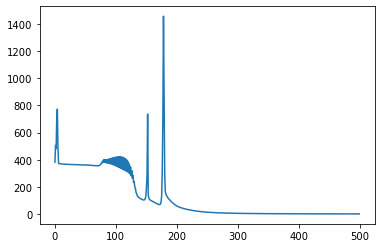

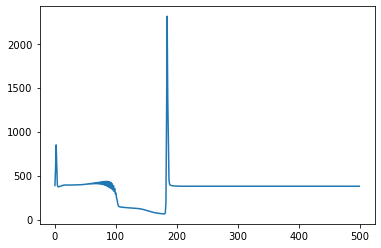

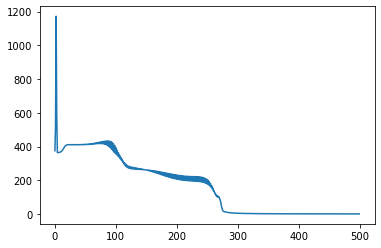

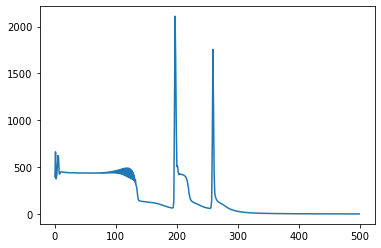

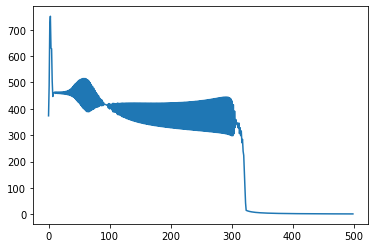

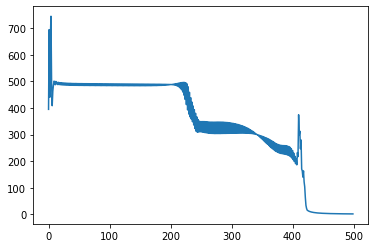

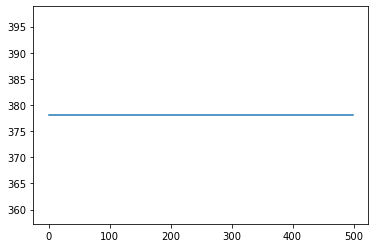

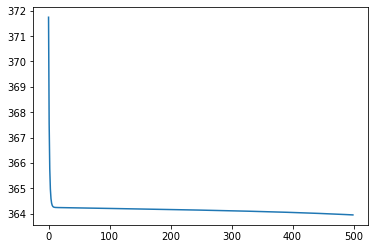

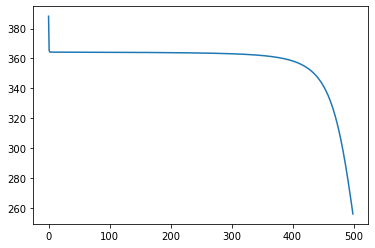

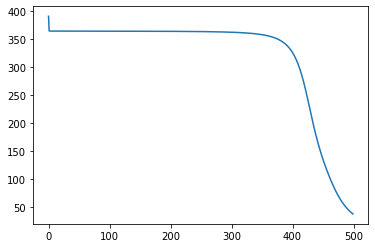

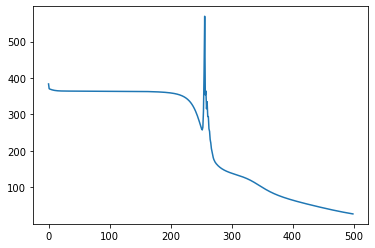

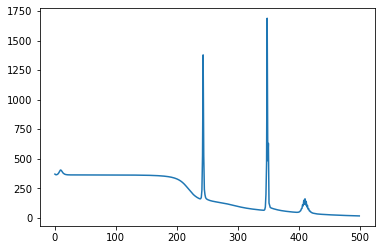

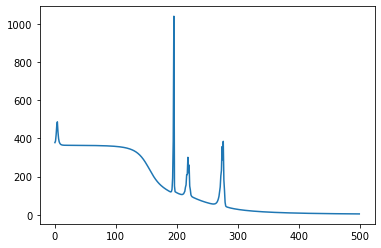

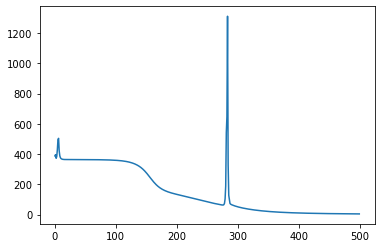

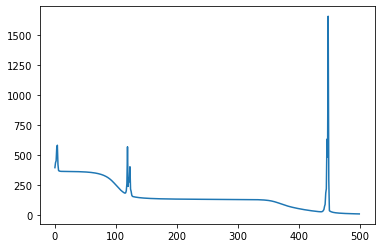

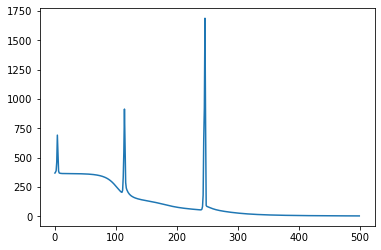

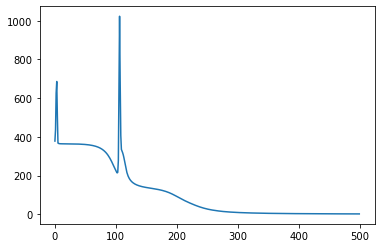

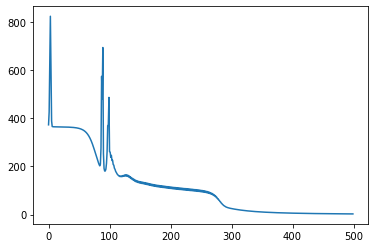

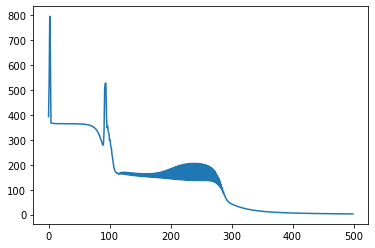

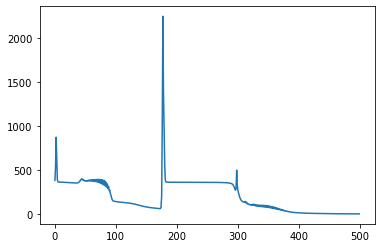

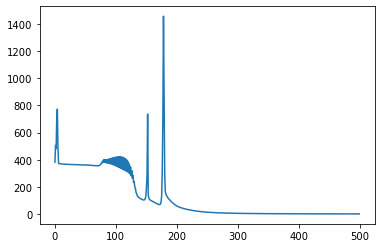

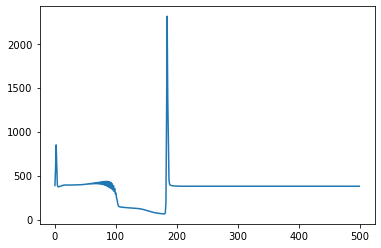

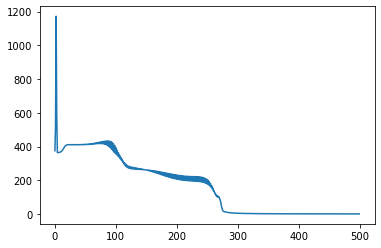

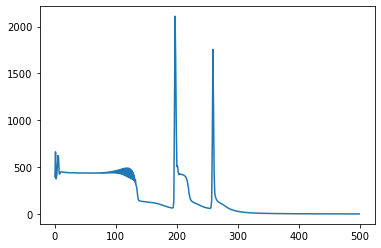

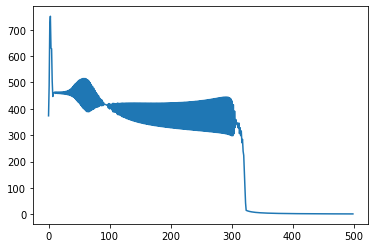

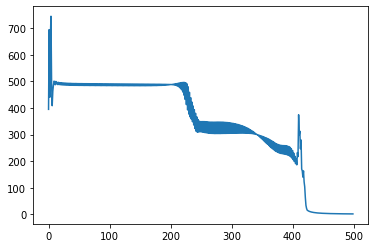

In [59]:
for i in range(20):
    layers = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]
    nn = NeuralNetwork(layers)
    loss = NLLLoss()
    fit(nn, loss, n_epoch=500, learning_rate=0.001*i)

Отличная визуализация: http://playground.tensorflow.org/

## Домашнее задание:

* Подоберите темп обучения. Как меняется сходимость? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate


In [60]:
def min_loss(nn, loss, learning_rate, n_epoch=500):
    loss_array = []
    for epoch in range(n_epoch):
        nn_predict = nn.forward(X)
        L = loss.forward(nn_predict, y)
        loss_array.append(L.sum())
        dLdy = loss.backward()
        nn.backward(dLdy)
        nn.step(learning_rate)
    return min(loss_array)

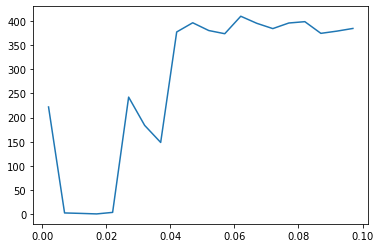

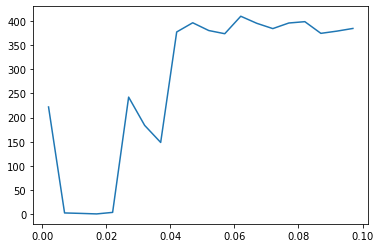

In [61]:
learning_rates = np.arange(0.002, 0.1, 0.005)
loses_by_lr = []
for learning_rate in learning_rates:
    layers = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]
    nn = NeuralNetwork(layers)
    loss = NLLLoss()
    loses_by_lr.append(min_loss(nn, loss, learning_rate=learning_rate))
plt.plot(learning_rates, loses_by_lr)

In [62]:
print("Best learning rate is {}".format(learning_rates[np.argmin(loses_by_lr)]))

Best learning rate is 0.017
Best learning rate is 0.017


* Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность?

In [63]:
class MSELoss:
    def __init__(self):
        pass

    def forward(self, X, y):
        self.n = X.shape[0]
        self.L = np.mean(np.square(X-y[:,None]))
        self.X = X
        self.y = y
        return self.L

    def backward(self, dLdy=0):
        self.dLdx = 2*(self.X - self.y[:, None])/self.n
        return self.dLdx

    def step(self, learning_rate=0):
        pass

In [64]:
class NeuralNetworkRegressor(NeuralNetwork):
    def predict(self, X):
        return np.rint(self.forward(X)).flatten()

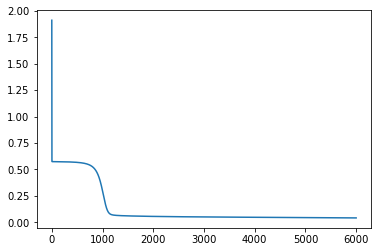

Loss: 0.041980865659911715


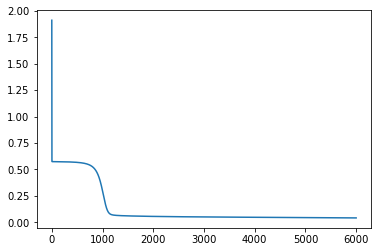

Loss: 0.041980865659911715


In [65]:
layers = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 1)]
nn_regressor = NeuralNetworkRegressor(layers)
loss = MSELoss()
print("Loss: {}".format(fit(nn=nn_regressor, loss=loss, n_epoch=6000, learning_rate=0.097)))

Изменилась ли разделяющая поверхность?

<AxesSubplot:>

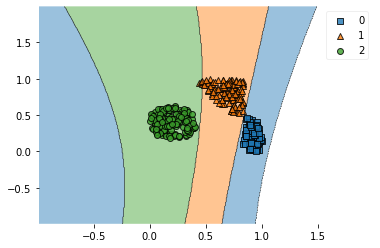

<AxesSubplot:>

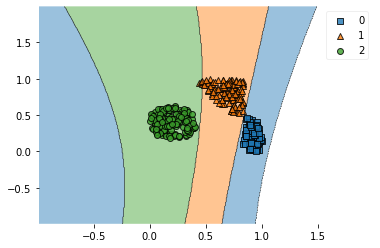

In [66]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plot_decision_regions(X, y, nn_regressor)